In [273]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt


In [274]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv' \


df = pd.read_csv(data)


df.head().T


,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [275]:

categoricas= ['lead_source', 'industry', 'employment_status', 'location']
numericas = ['number_of_courses_viewed','annual_income', 'interaction_count', 'lead_score']

In [276]:
for col in df[numericas]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(0)
    print(df[col].isnull().sum())



for col in df[categoricas]:
    df[col] = df[col].fillna('NA')
    print(df[col].isnull().sum())




0
0
0
0
0
0
0
0


In [277]:
df_full_train, df_test = train_test_split(df, test_size= 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']


In [278]:
#Q1

from sklearn.metrics import roc_auc_score

scores = []

for col in numericas:
    score = df_train[col]

    auc = roc_auc_score(y_train, score)

    if auc < 0.5:
        score_inv = -score
        auc = roc_auc_score(y_train, score_inv)

    print((f"{col}, {auc:.4f}" ))

number_of_courses_viewed, 0.7636
annual_income, 0.5520
interaction_count, 0.7383
lead_score, 0.6145


In [279]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train[numericas] = scaler.fit_transform(df_train[numericas])
df_val[numericas]   = scaler.transform(df_val[numericas])

In [280]:
#Q2
dict_train= df_train.to_dict(orient='records')
dict_val= df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train= dv.fit_transform(dict_train)
X_val= dv.transform(dict_val)

# Modelo
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:, 1]


score_orig = accuracy_score(y_val, y_pred)
Accuracy = np.round(score_orig,2)
Accuracy



np.float64(0.85)

In [281]:
from sklearn.metrics import roc_curve

from sklearn.metrics import auc


fpr, tpr, thresholds = roc_curve(y_val, y_pred)

auc(fpr, tpr)

roc_auc_score(y_val,y_pred_prob)

0.920956763493433

C:\Users\TALIGENT\AppData\Local\Temp\ipykernel_10424\2118219730.py:21: RuntimeWarning: invalid value encountered in scalar divide
  p = tp  / (tp + fp)


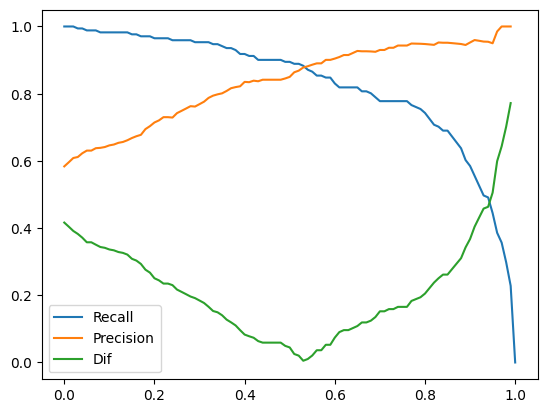

In [282]:
#Q3
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.linspace(0,1, 101)

Matriz = []

for t in thresholds:
    pred_positive = (y_pred_prob >= t)
    pred_negative= (y_pred_prob < t)

#VERDADEROS POSITIVOS Y NEGATIVOS
    tp = (pred_positive & actual_positive).sum()
    tn = (pred_negative & actual_negative).sum()

#FALSOS POSITIVOS Y NEGATIVOS
    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()

    p = tp  / (tp + fp)
    r = tp / (tp + fn)
    dif = np.abs(p-r)

    Matriz.append((t,tp,tn,fp,fn,p,r,dif))

columns = ['thresholds','tp','tn','fp','fn','precision','recall','dif']
df_pr = pd.DataFrame(Matriz, columns= columns)

plt.plot(df_pr.thresholds, df_pr.recall, label='Recall')
plt.plot(df_pr.thresholds, df_pr.precision, label='Precision')
plt.plot(df_pr.thresholds, df_pr.dif, label='Dif')

plt.legend()

In [289]:
dif_min = df_pr.dif.min()
df_pr.thresholds[df_pr.dif == dif_min]

53    0.53
Name: thresholds, dtype: float64

53    0.53
Name: thresholds, dtype: float64

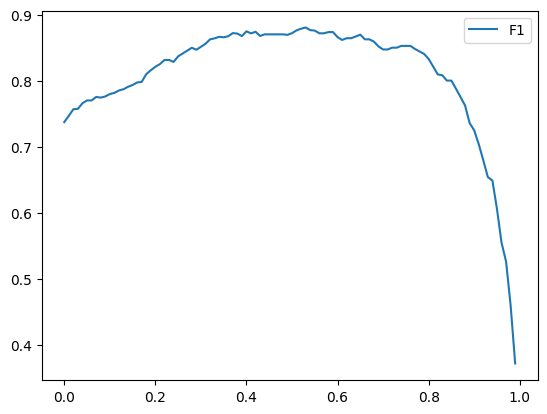

In [290]:
df_pr['F1'] = 2*((df_pr.precision * df_pr.recall)/(df_pr.precision + df_pr.recall))
plt.plot(df_pr.thresholds, df_pr.F1, label='F1')
plt.legend()

F1_max = df_pr.F1.max()

df_pr.thresholds[df_pr['F1']== F1_max]

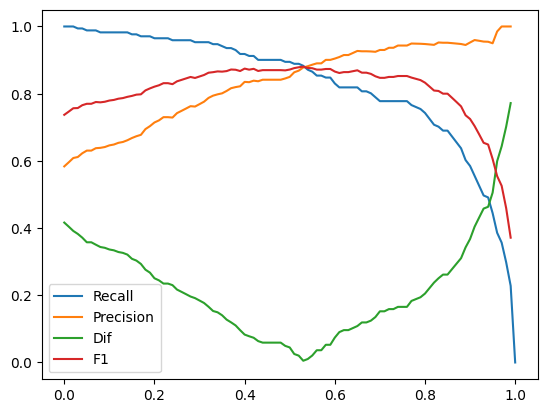

In [285]:
plt.plot(df_pr.thresholds, df_pr.recall, label='Recall')
plt.plot(df_pr.thresholds, df_pr.precision, label='Precision')
plt.plot(df_pr.thresholds, df_pr.dif, label='Dif')
plt.plot(df_pr.thresholds, df_pr.F1, label='F1')

plt.legend()

In [286]:

def train(df_train,y_train,C):
    train_dict = df_train[categoricas + numericas].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model
dv, model = train(df_train, y_train, C=0.001)

def prediccion(df_val,dv,model):
    val_dict = df_val[categoricas + numericas].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

y_pred = prediccion(df_val, dv, model)

In [ ]:
#Q5
from sklearn.model_selection import KFold


n_splits = 5 


Kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)


scores = []

for(train_idx, val_idx) in Kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train,y_train,C=1.0)
    y_pred = prediccion(df_val,dv,model)

    auc = roc_auc_score(y_val,y_pred)
    scores.append(auc)

print(np.std(scores))

0.03580711942905165


In [288]:
#Q6

n_splits = 5 

for C in [0.000001, 0.001, 1]:
    Kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)


    scores = []

    for(train_idx, val_idx) in Kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train,y_train,C=1.0)
        y_pred = prediccion(df_val,dv,model)

        auc = roc_auc_score(y_val,y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
# el C mas bajo

C=1e-06 0.822 +- 0.036
C=0.001 0.822 +- 0.036
C=1 0.822 +- 0.036
